In [96]:
# load necessary libraries for ETL. install what you don't have
import numpy as np
import pandas as pd
import requests
import requests
import urllib
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import sklearn 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [97]:
'''
@article{hou2024bridging,
  title={Bridging Language and Items for Retrieval and Recommendation},
  author={Hou, Yupeng and Li, Jiacheng and He, Zhankui and Yan, An and Chen, Xiusi and McAuley, Julian},
  journal={arXiv preprint arXiv:2403.03952},
  year={2024}
}
'''
file_meta = "../DATA/movies_metadata_reduced.jsonl"
meta_list = [json.loads(line) for line in open(file_meta, 'r')]


file_rev = "../DATA/movies_reviews_reduced.jsonl"
rev_list = [json.loads(line) for line in open(file_rev, 'r')]
rev_list[0]


{'rating': 5.0,
 'title': 'Must watch!',
 'text': 'I love this series!',
 'parent_asin': 'B00PSLQYWE'}

In [98]:
# make a data frame for the reviews 
rev_df = pd.DataFrame(rev_list)
rev_df.head(40)


,rating,title,text,parent_asin
0,5.0,Must watch!,I love this series!,B00PSLQYWE
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG
5,5.0,Five Stars,Excelent.,B00RL9WRAE
6,5.0,Five Stars,great comedy..I love these shows and the quali...,B00EC828DI
7,4.0,"Believe in yourself, not your appearance",Penelope is a modern-day fairytale involving a...,B0011N1WE8
8,4.0,Fans of Ghost and Mrs. Muir and Somewhere in T...,Jennifer Jones ([[ASIN:B00008LDO7 The Song of ...,B0002KPHYC
9,5.0,Great Memories,"Was just as ""she"" remembered it. Great Gift, ...",B002C6A6FY


In [99]:
# make a data frame for the metadata? 
# dropping movies that don't have a title
meta_df = pd.DataFrame(meta_list).drop(columns=['images', 'videos','subtitle','description', 'price', 'bought_together', 'title', 'categories','author', 'store', 'features'])
meta_df.head()
meta_df.isna().sum()

main_category     351
average_rating      3
rating_number       3
details             0
parent_asin         0
dtype: int64

In [100]:
print(len(meta_df))
print(len(meta_df[meta_df['main_category'] == 'Prime Video']))
print(len(meta_df[meta_df['main_category'] == 'Movies & TV']))
prime_df = meta_df[meta_df['main_category'] == 'Prime Video']


7477
3488
3612


In [101]:
prime_df['average_rating'].corr(prime_df['rating_number'])
prime_df.head()
#meta_df.isna().sum()

,main_category,average_rating,rating_number,details,parent_asin
0,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ...",B0728FHHYC
2,Prime Video,3.1,8.0,"{'Audio languages': ['English'], 'Subtitles': ...",B00O8NP6XQ
5,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ...",B077QNR8Q6
7,Prime Video,4.1,165.0,"{'Content advisory': ['Violence', 'substance u...",B09CZJW2Q9
10,Prime Video,4.3,38.0,"{'Subtitles': ['None available'], 'Directors':...",B071L45H6W


In [102]:
df_merged = rev_df.merge(prime_df, on='parent_asin', how='right')
df_merged.head()
# aughhhh the colums are not merging right aauughhhh

,rating,title,text,parent_asin,main_category,average_rating,rating_number,details
0,3.0,Predictable but with promise,It had a pacing problem. It was slow in parts ...,B0728FHHYC,Prime Video,3.4,29.0,"{'Audio languages': ['English'], 'Subtitles': ..."
1,1.0,One Star,Did not really like this movie. It was a bit o...,B00O8NP6XQ,Prime Video,3.1,8.0,"{'Audio languages': ['English'], 'Subtitles': ..."
2,5.0,Five Stars,fun,B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."
3,4.0,Worth the time,"Falls short of the book, of course, but a good...",B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."
4,5.0,Be ready to have your heart racing as quickly ...,I read the book on which this series is based....,B077QNR8Q6,Prime Video,4.7,3957.0,"{'Audio languages': ['English'], 'Subtitles': ..."


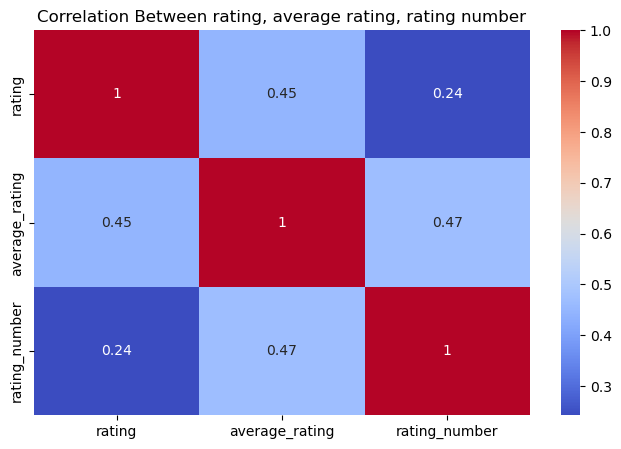

In [103]:
corr_df = df_merged.select_dtypes(include=['float64'])
correlation_matrix = corr_df.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between rating, average rating, rating number')
plt.show()


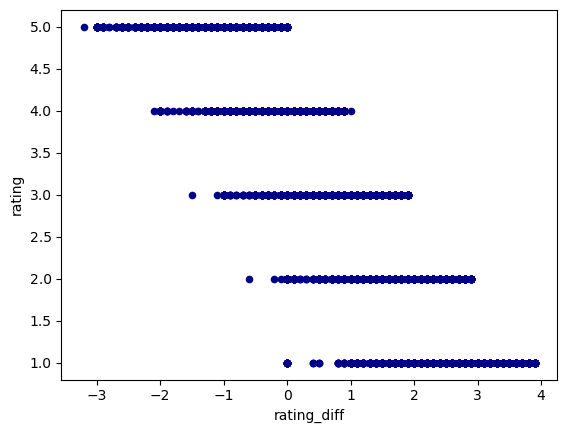

In [104]:
# take count of descriptors im in the details column

# postive diff = user is lower than average, negative diff = user is higher than average 
df_merged['rating_diff'] = df_merged['average_rating'] - df_merged['rating']
ax1 = df_merged.plot.scatter(x='rating_diff',

                      y='rating',

                      c='DarkBlue')

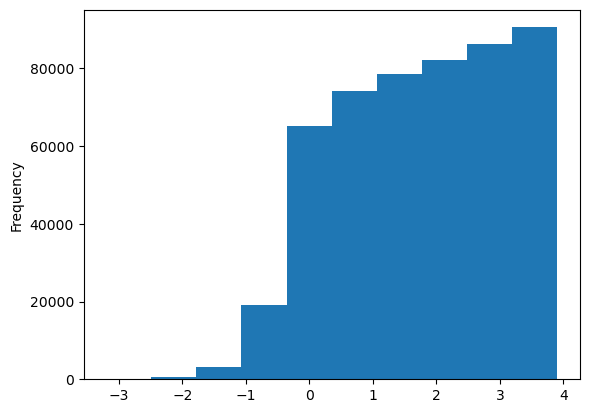

In [105]:
ax = df_merged["rating_diff"].plot.hist(orientation="vertical", cumulative=True)
#postive diff = user is lower than average, negative diff = user is higher than average 


In [106]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ethanogilvie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
def get_sentiment_scores(df):
    # Create an empty list to store sentiment scores
    sentiment_scores = []

    # Iterate over each review text
    for review in df["text"]:
        sentiment = sia.polarity_scores(str(review))  # Convert to string & analyze
        sentiment_scores.append(sentiment["compound"])  # Extract compound score

    # Add sentiment score column
    df["sentiment_score"] = sentiment_scores

    return df  


In [108]:
rev_df_s = get_sentiment_scores(rev_df)
rev_df_s.head(100)

,rating,title,text,parent_asin,sentiment_score
0,5.0,Must watch!,I love this series!,B00PSLQYWE,0.6696
1,5.0,number 2 in the series and its a good one - lo...,number 2 in the series and its a good one - lo...,B003PIUC02,0.8748
2,5.0,Great price for blue ray,Gift for son. Great price for blue ray.,B004R6JG7G,0.7906
3,5.0,Miracle on 34th Street,"I purchased this as a gift, along with some ot...",B075498GH2,0.9825
4,5.0,Twilight Saga,"I have always liked vampire movies, & Twilight...",B01JTQ3LFG,0.6908
...,...,...,...,...,...
95,3.0,Not quite right in interpetation of biblical p...,I gave it a 3. You really have to know your Bi...,B0847V9B7K,0.8869
96,3.0,Pride Fighting Championships 29: Fists of Fluf...,"As usual, Pride puts on another great show. Ye...",B000CSTKJW,0.9969
97,2.0,Jason dies and is reborn into movie hell,I have always been a fan of the Friday the 13t...,B00006FDBT,0.2365
98,5.0,"I won't be popular for my review, but here goe...",Maybe I just LOVE the grittiness and despair i...,B000O77SF4,0.9896


In [109]:
#transform variable to array
y = rev_df_s['rating'].to_numpy()
x = rev_df_s['sentiment_score'].to_numpy()


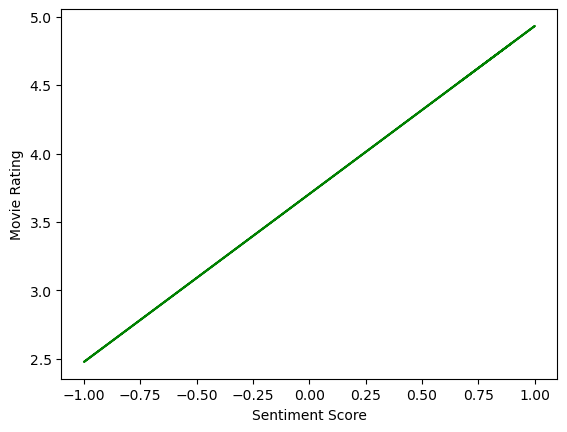

In [110]:
# plot the regression line

# predict the sentiment score with regression model
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def estimate_coef(x, y):
  # number of observations/points
  n = np.size(x)

  # mean of x and y vector
  m_x = np.mean(x)
  m_y = np.mean(y)

  # calculating cross-deviation and deviation about x
  SS_xy = np.sum(y*x) - n*m_y*m_x
  SS_xx = np.sum(x*x) - n*m_x*m_x

  # calculating regression coefficients
  b_1 = SS_xy / SS_xx
  b_0 = m_y - b_1*m_x

  return (b_0, b_1)

def plot_regression_line(x, y, b):
  # plotting the actual points as scatter plot
  #plt.scatter(x, y, color = "m",
       # marker = "o", s = 30)

  # predicted response vector
  y_pred = b[0] + b[1]*x

  # plotting the regression line
  plt.plot(x, y_pred, color = "g")

  # putting labels
  plt.xlabel('Sentiment Score')
  plt.ylabel('Movie Rating')

b_array = []


b_array = estimate_coef(x, y)

plot_regression_line(x, y, b_array)


In [117]:
# test the linear model
model = linear_model.LinearRegression()

# model = linear regression
# x = sentiment score
# y = ratings
# scoring = the way we evaluate success of the predictive model, did neg mean square error, might modify depending on interpretation
# cv = "subsets" to test the data. 
mse_scores = cross_val_score(model, x.reshape(-1, 1), y.reshape(-1, 1), scoring='neg_mean_squared_error', cv=5)
cv_mse = -mse_scores
mean_cv_mse = np.mean(cv_mse)
print(mse_scores)
print("Average of scores made positive: ", mean_cv_mse)
# output right now: the neg mean sequare error of each. 
# default output (remove the scoring parameter) = 



[-1.15213354 -1.15426228 -1.18062682 -1.20500851 -1.34291891]
Average of scores:  1.2069900114701146


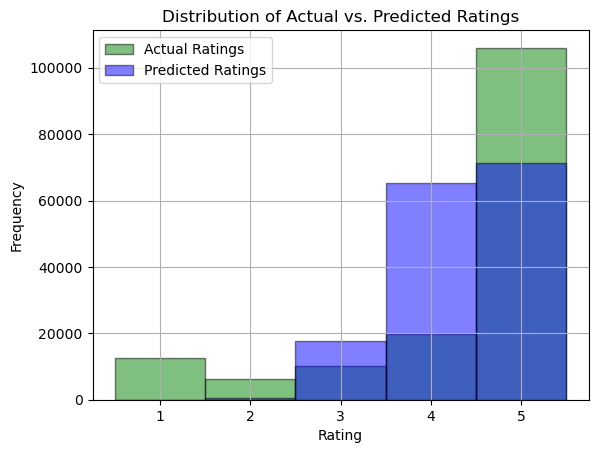

In [112]:

y_pred = b_array[0] + b_array[1] * x

# Define the bins for ratings 1-5
bins = np.arange(1, 7) - 0.5  # This creates bins for 1, 2, 3, 4, 5

# Plotting Actual and Predicted Ratings
plt.hist(y, bins=bins, alpha=0.5, label='Actual Ratings', color='green', edgecolor='black')
plt.hist(y_pred, bins=bins, alpha=0.5, label='Predicted Ratings', color='blue', edgecolor='black')

# Set labels, title, and grid
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Ratings')

# Set the x-ticks to 1, 2, 3, 4, 5, so the x-axis shows only these integer values
plt.xticks([1, 2, 3, 4, 5])

# Add a legend and grid
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()


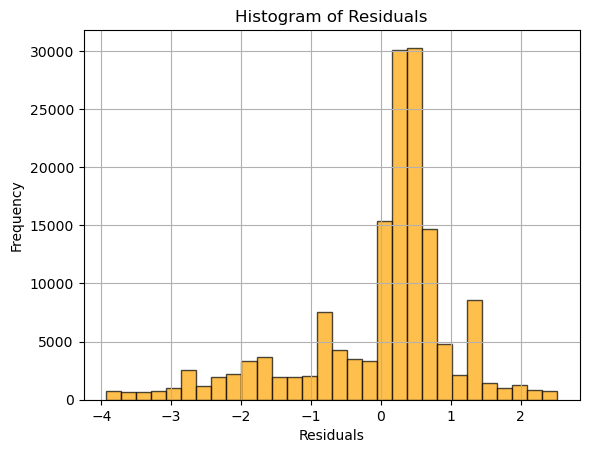

In [113]:
# Calculate predictions using the regression line coefficients
y_pred = b_array[0] + b_array[1] * x

# Calculate residuals (actual - predicted)
residuals = y - y_pred

# Create a histogram of the residuals
plt.hist(residuals, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()



Cross-Validated Mean Squared Error: 1.2070
Final Test Mean Squared Error: 1.1945
Final Test R-squared Score: 0.2240


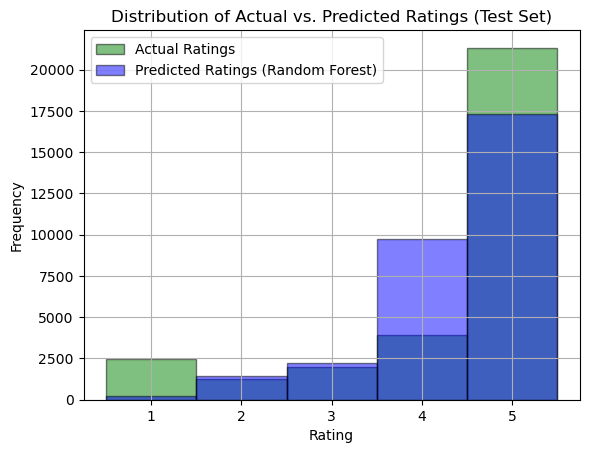

In [114]:
# Replicating the methodology above but this time with a randomforest regression model instead of linear regression (classifier seemed to perform worse?)

# Initialize the new model
rf_model = RandomForestRegressor(n_estimators=100, random_state=6)

# 1. Perform Cross-Validation on new model (This one performs slightly worse in terms of mse versus the linear model)
cv_scores = cross_val_score(model, x.reshape(-1, 1), y.reshape(-1, 1), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores  # Convert to positive MSE
mean_cv_mse = np.mean(cv_mse)

print(f"Cross-Validated Mean Squared Error: {mean_cv_mse:.4f}")

# 2. Fit new model and test MSE and r2 of the fitted model that uses the split test vs. train data as opposed to the cross_val score (cross_val_score is likely more reliable but this also provides an additional metric)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Final Test Mean Squared Error: {mse:.4f}")
print(f"Final Test R-squared Score: {r2:.4f}")

# Plotting the actual ratings vs predicted ones in a histogram for the randomforest regression model (seems better than linear model)
#Predictions are made with continious numbers to capture some of the nuance in reviews but then rounded to nearest integer for graph purposes
bins = np.arange(1, 7) - 0.5  # Bins for ratings 1-5

plt.hist(y_test, bins=bins, alpha=0.5, label='Actual Ratings', color='green', edgecolor='black')
plt.hist(y_pred_rf, bins=bins, alpha=0.5, label='Predicted Ratings (Random Forest)', color='blue', edgecolor='black')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Ratings (Test Set)')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


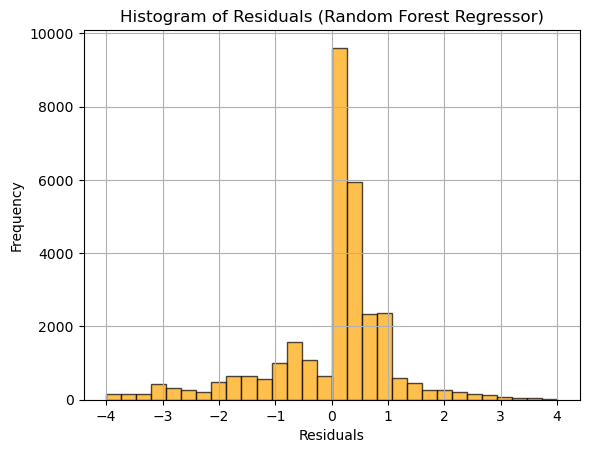

In [115]:
# 1. Calculate predictions using the fitted Random Forest model
y_pred_rf = rf_model.predict(X_test)

# 2. Calculate residuals (actual - predicted)
residuals_rf = y_test - y_pred_rf

# 3. Create a histogram of the residuals
plt.hist(residuals_rf, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Random Forest Regressor)')
plt.grid(True)
plt.show()


In [116]:
# 1. Make predictions using the fitted Random Forest model
y_pred_rf = rf_model.predict(X_test)

# 2. Round the predictions to the nearest integer (since ratings are discrete)
y_pred_rf_rounded = np.round(y_pred_rf).astype(int)

# 3. Calculate the accuracy by comparing the rounded predictions to the actual ratings
accuracy = np.mean(y_pred_rf_rounded == y_test) * 100  # Multiply by 100 to get percentage

print(f"Accuracy of the Random Forest model: {accuracy:.2f}%")


Accuracy of the Random Forest model: 53.13%
